In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import seaborn as sns
from IPython.display import display
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 Caga y Exploración

**Exploración:** Valores nulos, Duplicados, Rango de las variables, Incoherencias, Distribución inicial de columnas

## 1.1 Contexto de las variables
El presente conjunto de datos procede del registro personal de gastos realizado de forma manual y sistemática por el usuario a lo largo de un periodo prolongado de tiempo. Su registro fue en dos fuentes diferenciadas:

•	Por un lado, se utilizó la aplicación móvil **Money Manager**, donde se registraron todas las transacciones económicas. En esta herramienta se clasificaron como Expenses los desembolsos personales y como Income las transacciones compartidas o reembolsadas, exceptuando casos concretos como *Blablacar* y *Wallapop*, que fueron tratados explícitamente como ingresos. En adelante, este primer conjunto de datos será denominado “gastos”, ya que recoge el gasto global y consolidado del individuo.

![1 Money Manager.png](../imagenes/1 Money Manager.png)

•	La segunda fuente corresponde a una **hoja de cálculo almacenada en Google Drive** diseñada para documentar el consumo de combustible por trayectos. Este documento contiene distintas pestañas, entre ellas Combo (vehículo principal del usuario), donde se registraron todos los desplazamientos, y *Subaru* y *Pixo*, correspondientes a vehículos adicionales utilizados esporádicamente y con menor frecuencia de anotación. A partir de este punto, este dataset será referido como “coche”, dado que representa el coste asociado al uso de vehículo privado.

![2 Hoja Drive.png](../imagenes/2 Hoja Drive.png)

## 1.2 Carga y identificar estructura del dataset: dimensiones y columnas

### 1.2.1 Carga
 Importar el dataset.

In [206]:
# Rutas posibles (GitHub / Drive)
rutas_xlsx = [
    "data/dataset.xlsx",  # GitHub
    "/content/drive/MyDrive/Proyecto 1 - Limpieza - Finanzas Personales/data/dataset.xlsx"  # Drive Albert
]

rutas_csv = [
    "data/dataset_en_csv.csv",  # GitHub
    "/content/drive/MyDrive/Proyecto 1 - Limpieza - Finanzas Personales/data/dataset.csv"  # Drive Albert
]

In [207]:
gastos = None
# 1) Intentar cargar versión CSV
for ruta in rutas_csv:
    if os.path.exists(ruta):
        gastos = pd.read_csv(ruta)
        print(f"✔ CSV encontrado y cargado: {ruta}")
        break

# 2) Si no se carga el CSV, cargar XLSX, crear CSV y guardar
if gastos is None:
    for ruta in rutas_xlsx:
        if os.path.exists(ruta):
            print(f"⚙ Cargando Excel original desde: {ruta}")
            gastos = pd.read_excel(ruta)

            # Guardar CSV limpio
            salida = rutas_csv[rutas_xlsx.index(ruta)]
            gastos.to_csv(salida, index=False, encoding="utf-8")

            print(f"📁 CSV generado correctamente en: {salida}")
            break

# 3) Si nada funciona → mensaje
if gastos is None:
    raise FileNotFoundError("❌ No se encontró ni dataset.xlsx ni dataset_en_csv.csv en ninguna ruta.")
else:
    print("\n🏁 Dataset disponible y listo para trabajar.")
    display(gastos.head())

✔ CSV encontrado y cargado: /content/drive/MyDrive/Proyecto 1 - Limpieza - Finanzas Personales/data/dataset.csv

🏁 Dataset disponible y listo para trabajar.


,Date,Income/Expenses,Category,Memo,Amount
0,2025-11-29,Expenses,Transportation,Bici Olot-Girona. Bus de Girona a Olot,-9.10
1,2025-11-29,Expenses,Food,"Ezmorzar. Croissant, Napolitana, Llet",-5.70
2,2025-11-29,Expenses,Gasolina,"43,13 L",-56.03
3,2025-11-16,Expenses,Gasolina,"Pixo. 21,64 L",-28.33
4,2025-11-14,Expenses,Food,Sopar. JL colla. Xino. Yakisoba i gyozas,-13.85


In [208]:
# Renombro la columna Date para que se llame "Date" y no "ï»¿Date"
gastos.rename(columns={'ï»¿Date': 'Date'}, inplace=True)
gastos.head()

,Date,Income/Expenses,Category,Memo,Amount
0,2025-11-29,Expenses,Transportation,Bici Olot-Girona. Bus de Girona a Olot,-9.10
1,2025-11-29,Expenses,Food,"Ezmorzar. Croissant, Napolitana, Llet",-5.70
2,2025-11-29,Expenses,Gasolina,"43,13 L",-56.03
3,2025-11-16,Expenses,Gasolina,"Pixo. 21,64 L",-28.33
4,2025-11-14,Expenses,Food,Sopar. JL colla. Xino. Yakisoba i gyozas,-13.85


### 1.2.2 Revisar dimensiones y columnas

In [209]:
print(f"Filas: {gastos.shape[0]}  |  Columnas: {gastos.shape[1]}")

Filas: 1402  |  Columnas: 5


In [210]:
print(
    f"El dataset contiene {gastos.shape[0]} registros y {gastos.shape[1]} características.\n"
    "Las características o columnas disponibles son:\n"
    f"- " + "\n- ".join(gastos.columns)
)


El dataset contiene 1402 registros y 5 características.
Las características o columnas disponibles son:
- Date
- Income/Expenses
- Category
- Memo
- Amount


|     Columnas    |                                                             Significado / Descripción                                                             |
|:---------------:|:-------------------------------------------------------------------------------------------------------------------------------------------------:|
| Date            | Fecha del gasto. Ingresada manualmente por el usuario y, en ausencia de edición, coincide con la fecha de registro. Formato YYYY-MM-DD.           |
| Income/Expenses | Indica si la operación corresponde a un gasto del usuario (Expenses) o a un importe recibido por reparto de costes (Income). Selección manual.    |
| Category        | Categoría asignada al gasto. Puede ser una categoría predeterminada en inglés o creada por el propio usuario.                                     |
| Memo            | Campo de texto libre con notas descriptivas del gasto. Incluye subcategorías separadas por punto y espacio, junto con comentarios relevantes.     |
| Amount          | Importe económico asociado a la operación. Se expresa en euros: valores negativos representan gastos y valores positivos corresponden a ingresos. |

### 1.3 Inspeccionar tipos de datos
Sobre las 5 variables presentadas, sus tipos de datos deberían ser:
- **Date:** Tipo fecha, datetime
- **Income/Expenses**: Tipo string
- **Category**: Tipo string
- **Memo**: Tipo string
- **Amount**: Tipo decimal, float. Únicamente con dos decimales (ya que se trata de cantidades monetarias)

Se comprueba que es así.

In [211]:
print(gastos.dtypes)

Date                object
Income/Expenses     object
Category            object
Memo                object
Amount             float64
dtype: object


In [216]:
# Como Date ha salido con formato object, se cambia a formato datetime
gastos['Date'] = pd.to_datetime(gastos['Date'], errors='coerce')

In [217]:
print(gastos.dtypes)

Date               datetime64[ns]
Income/Expenses            object
Category                   object
Memo                       object
Amount                    float64
dtype: object


In [218]:
for col in ['Income/Expenses', 'Category', 'Memo']:
    # Verificar si todos los valores son strings
    all_strings = gastos[col].map(lambda x: isinstance(x, str)).all()

    if all_strings:
        print(f"La columna '{col}' contiene únicamente strings.")
    else:
        print(f"La columna '{col}' NO contiene solo strings.")

La columna 'Income/Expenses' contiene únicamente strings.
La columna 'Category' contiene únicamente strings.
La columna 'Memo' contiene únicamente strings.


In [219]:
# Verificar si cada valor tiene más de 2 decimales
mask = gastos['Amount'].map(lambda x: round(x, 2) != x)
invalid_values = gastos[mask]

if invalid_values.empty:
    print("Todos los valores de 'Amount' tienen como máximo dos decimales.")
else:
    print("Estos valores de 'Amount' tienen más de dos decimales:")
    print(invalid_values[['Amount']])

Todos los valores de 'Amount' tienen como máximo dos decimales.


## 1.4 ¿Cuál es el dominio del dataset?
Sobre las 5 variables, su dominio debería ser:
- **Date:** Fechas entre septiembre de 2021 hasta el noviembre de 2025 siendo todas fechas válidas.
- **Income/Expenses:** Sólo debería contener strings "Income" y strings "Expenses".
- **Category:** Debería contener distintas categorías por defecto o escogidas por el usuario. Se espera que, al ser una introducción manual quizás hayan muchas categorías, algunas erróneas, algunas demasiado generales o algunas demasiado específicas.
- **Memo:** El dominio alberga una gran variedad de textos, pocos únicos y de una longitud de texto que puede variar mucho también.
- **Amount:** Se esperan valores negativos y positivos, siendo mayoritariamente (número, media y mediana) valores negativos ya que básicamente se registran los datos. No se esperan valores positivos mayores a 1000 (no recibir más de 1000€ en compartir gastos)  ni negativos mayores a -22.100 (compra de un coche) ya que sería fuera de una cantidad lógica en el contexto de las finanzas personales del usuario.

Se comprueba que es así.

### 1.4.1 Dominio de Date

In [220]:
gastos.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,1402,2023-11-25 18:43:39.115549184,2021-09-30 00:00:00,2023-01-21 12:00:00,2023-10-23 00:00:00,2024-10-13 00:00:00,2025-11-29 00:00:00,NaN
Amount,1402.0,-36.599786,-22055.0,-20.6125,-8.865,-3.8075,505.0,596.042708


In [221]:
desc_date = gastos['Date'].describe()

print("Estadísticas de la columna 'Date':")
print(f"  - Número de registros: {desc_date['count']}")
print(f"  - Fecha mínima: {desc_date['min'].date()}")
print(f"  - Fecha máxima: {desc_date['max'].date()}")

Estadísticas de la columna 'Date':
  - Número de registros: 1402
  - Fecha mínima: 2021-09-30
  - Fecha máxima: 2025-11-29
  - Primer cuartil (25%): 2023-01-21
  - Mediana (50%): 2023-10-23
  - Tercer cuartil (75%): 2024-10-13



In [249]:
print(f"El dominio de las fechas se extiende desde {desc_date['min'].date()} hasta {desc_date['max'].date()} con una precisión de 1 día.")

El dominio de las fechas se extiende desde 2021-09-30 hasta 2025-11-29 con una precisión de 1 día.


### 1.4.2 Dominio de Income/Expenses

In [223]:
# Se listan los valores únicos.
valores_unicos = gastos['Income/Expenses'].unique()
print("Valores únicos de la columna Income/Expenses:", valores_unicos)

# Se comprueba su esos valores están dentro del conjunto de valores permitido
permitidos = {"Income", "Expenses"}
solo_valores_correctos = set(valores_unicos).issubset(permitidos)

if solo_valores_correctos:
    print("Todos los valores son 'Income' o 'Expenses'")
else:
    print("Algunos valores no son 'Income' ni 'Expenses'")

Valores únicos de la columna Income/Expenses: ['Expenses' 'Income']
Todos los valores son 'Income' o 'Expenses'


### 1.4.3 Dominio de Category

In [224]:
gastos['Category'].describe()

,Category
count,1402
unique,48
top,Food
freq,396


In [225]:
desc_category = gastos['Category'].describe()

print("Estadísticas de la columna 'Category':")
print(f"  - Número total de registros: {desc_category['count']}")
print(f"  - Número de categorías únicas: {desc_category['unique']}")
print(f"  - Categoría más frecuente: '{desc_category['top']}'")
print(f"  - Frecuencia de la categoría más frecuente: {desc_category['freq']}")

Estadísticas de la columna 'Category':
  - Número total de registros: 1402
  - Número de categorías únicas: 48
  - Categoría más frecuente: 'Food'
  - Frecuencia de la categoría más frecuente: 396


In [226]:
# Se listan los valores únicos.
valores_unicos = gastos['Category'].unique()
print("Valores únicos de la columna Category:", valores_unicos)

Valores únicos de la columna Category: ['Transportation' 'Food' 'Gasolina' 'Prendre algo' 'Atraccions' 'Sexe'
 'Gift' 'Bàsquet' 'Gasolina compartida' 'Cotxe compartit' 'Alcohol'
 'Obligatori' 'Tennis' 'Snacks' 'Supermercat' 'Car' 'Pàrquing' 'Tren'
 'Health' 'Perruqueria' 'Material ruta' 'Home' 'Furgo' 'Peatge'
 'Allotjament' 'Bizum' 'Vols' 'Lloguer cotxe' 'Education'
 'Projecte Boscos' 'Esquiar' 'Salary' 'Bici' 'Roba' 'Work' 'Banc'
 'Casament' 'Blablacar' 'Banc Sabadell' 'Excursió' 'Teatre i Cinema'
 'Salou' 'Jocs cartes / taula' 'pizza' 'Llibreria' 'Paintball'
 'Entertainment' 'Educació']


### 1.4.4 Dominio de Memo

In [227]:
print(gastos['Memo'].describe())


count                        1402
unique                       1351
top       Dinar. Menjador. Feina.
freq                            9
Name: Memo, dtype: object


In [228]:
desc_memo = gastos['Memo'].describe()

print("Estadísticas de la columna 'Memo':")
print(f"  - Número total de registros: {desc_memo['count']}")
print(f"  - Número de valores únicos: {desc_memo['unique']}")
print(f"  - Valor más frecuente: '{desc_memo['top']}'")
print(f"  - Frecuencia del valor más frecuente: {desc_memo['freq']}")

Estadísticas de la columna 'Memo':
  - Número total de registros: 1402
  - Número de valores únicos: 1351
  - Valor más frecuente: 'Dinar. Menjador. Feina.'
  - Frecuencia del valor más frecuente: 9


In [229]:
# Longitud de los memos
gastos['Memo_length'] = gastos['Memo'].astype(str).map(len)
print(gastos['Memo_length'].describe())


count    1402.000000
mean       29.241084
std        16.638760
min         3.000000
25%        17.000000
50%        27.000000
75%        37.750000
max       139.000000
Name: Memo_length, dtype: float64


In [230]:
desc_length = gastos['Memo_length'].describe()

print("Estadísticas de la longitud de los memos (número de caracteres):")
print(f"  - Número total de registros: {desc_length['count']}")
print(f"  - Longitud mínima de un memo: {desc_length['min']} caracteres")
print(f"  - Longitud máxima de un memo: {desc_length['max']} caracteres")
print(f"  - Longitud promedio de los memos: {desc_length['mean']:.2f} caracteres")
print(f"  - Desviación estándar de la longitud: {desc_length['std']:.2f} caracteres")
print(f"  - Primer cuartil (25%): {desc_length['25%']} caracteres")
print(f"  - Mediana (50%): {desc_length['50%']} caracteres")
print(f"  - Tercer cuartil (75%): {desc_length['75%']} caracteres")


Estadísticas de la longitud de los memos (número de caracteres):
  - Número total de registros: 1402.0
  - Longitud mínima de un memo: 3.0 caracteres
  - Longitud máxima de un memo: 139.0 caracteres
  - Longitud promedio de los memos: 29.24 caracteres
  - Desviación estándar de la longitud: 16.64 caracteres
  - Primer cuartil (25%): 17.0 caracteres
  - Mediana (50%): 27.0 caracteres
  - Tercer cuartil (75%): 37.75 caracteres


### 1.4.5 Dominio de Amount

In [231]:
gastos.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,1402,2023-11-25 18:43:39.115549184,2021-09-30 00:00:00,2023-01-21 12:00:00,2023-10-23 00:00:00,2024-10-13 00:00:00,2025-11-29 00:00:00,NaN
Amount,1402.0,-36.599786,-22055.0,-20.6125,-8.865,-3.8075,505.0,596.042708
Memo_length,1402.0,29.241084,3.0,17.0,27.0,37.75,139.0,16.63876


In [251]:
desc_amount = gastos['Amount'].describe()

print("Estadísticas de la columna 'Amount':")
print(f"  - Número de registros: {desc_amount['count']}")
print(f"  - Mínimo: {desc_amount['min']}")
print(f"  - Máximo: {desc_amount['max']}")

Estadísticas de la columna 'Amount':
  - Número de registros: 1400.0
  - Mínimo: -22055.0
  - Máximo: 50.0


In [250]:
print(f"\n El dominio de los datos se estiende desde : {desc_amount['min']} € hasta {desc_amount['max']} € con una precisión de 0.00 €")


 El dominio de los datos se estiende desde : -22055.0 € hasta 505.0 € con una precisión de 0.00 €


## 1.5 ¿La fuente de datos es fiable y completa?

## 1.6 ¿Los datos están agregados o son individuales (nivel de granularidad)?

## 1.7 ¿Hay valores nulos? ¿Cuál es su proporción?

In [236]:
print(gastos.isnull().sum())

Date               0
Income/Expenses    0
Category           0
Memo               0
Amount             0
Memo_length        0
dtype: int64


In [237]:
if gastos.isnull().sum().sum() == 0:
    print("No hay valores nulos en ninguna columna.")
else:
    proporcion = (gastos.isnull().mean() * 100).round(2)
    print("Proporción de valores nulos por columna (%):")
    for col, pct in proporcion.items():
        print(f"  - {col}: {pct}%")

No hay valores nulos en ninguna columna.


## 1.8 ¿Existen duplicados o registros anómalos?

In [238]:
print(f"Hay {gastos.duplicated().sum()} fila/s duplicada/s en el dataset.")

Hay 1 fila/s duplicada/s en el dataset.


In [239]:
print("Las filas duplicadas en el dataset son:\n")
print(gastos[gastos.duplicated(keep=False)])


Las filas duplicadas en el dataset son:

          Date Income/Expenses   Category                         Memo  \
810 2023-08-07          Income  Blablacar  Alps23. Montpellier-Venècia   
811 2023-08-07          Income  Blablacar  Alps23. Montpellier-Venècia   

     Amount  Memo_length  
810    42.0           27  
811    42.0           27  


## 1.9 ¿Las variables tienen una distribución razonable? ¿Existen outliers?

### 1.9.1 Distribución de Date

In [252]:
gastos.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,1400,2023-11-25 13:38:44.571428352,2021-09-30 00:00:00,2023-01-21 00:00:00,2023-10-23 00:00:00,2024-10-13 00:00:00,2025-11-29 00:00:00,NaN
Amount,1400.0,-37.042786,-22055.0,-20.6625,-8.9,-3.8375,50.0,596.288951
Memo_length,1400.0,29.26,3.0,17.0,27.0,38.0,139.0,16.637912


In [257]:
desc_date = gastos['Date'].describe()

print("Estadísticas de la columna 'Date':")
print(f"  - Promedio: {desc_date['mean'].date()}")
print(f"  - Primer cuartil (25%): {desc_date['25%'].date()}")
print(f"  - Mediana (50%): {desc_date['50%'].date()}")
print(f"  - Tercer cuartil (75%): {desc_date['75%'].date()}\n")

Estadísticas de la columna 'Date':
  - Promedio: 2023-11-25
  - Primer cuartil (25%): 2023-01-21
  - Mediana (50%): 2023-10-23
  - Tercer cuartil (75%): 2024-10-13



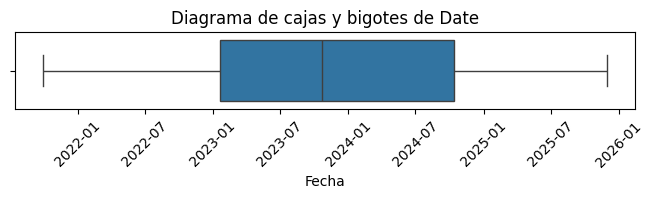

La cantidad de gastos hecha tiene una distribución más o menos uniforme en el tiempo.


In [240]:
plt.figure(figsize=(8, 1))
sns.boxplot(x=gastos['Date'])
plt.title("Diagrama de cajas y bigotes de Date")
plt.xlabel("Fecha")
plt.xticks(rotation=45)
plt.show()

print("La cantidad de gastos hecha tiene una distribución más o menos uniforme en el tiempo.")
print("No existen outliers.")

### 1.9.2 Distribución de Income/Expenses

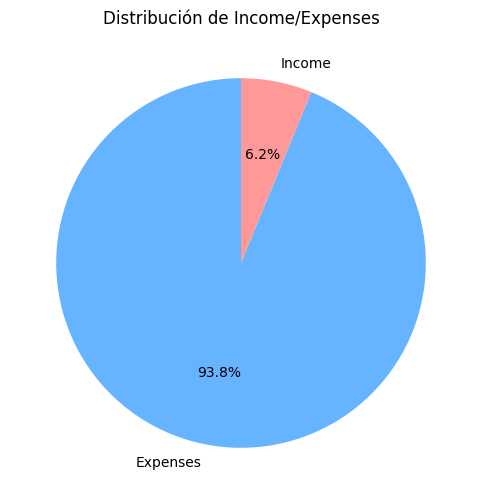

La mayoría de registros corresponen a gastos y una pequeña proporción a compartición de gastos.
No existen outliers.


In [263]:
conteo = gastos['Income/Expenses'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(conteo, labels=conteo.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title("Distribución de Income/Expenses")
plt.show()

print("La mayoría de registros corresponen a gastos y una pequeña proporción a compartición de gastos.")
print("No existen outliers.")

### 1.9.3 Distribución de Category

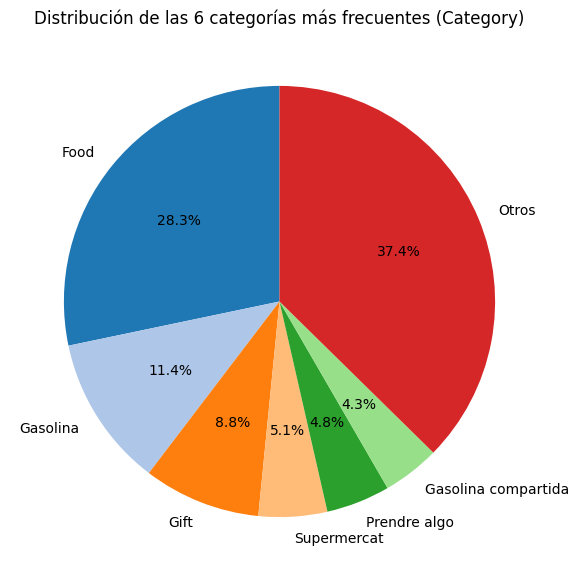

Así se distribuyen el número de gastos (no en cantidad) en las categorías más frecuentes.
No existen outliers aunque existen muchas categorías que se podrían agrupar ya que el número total de categorías existentes es 47.


In [266]:
conteo = gastos['Category'].value_counts()
top6 = conteo.head(6) # Tomar las 6 categorías más frecuentes
top6['Otros'] = conteo[6:].sum() # Agrupar el resto como "Otros"

plt.figure(figsize=(7,7))
plt.pie(top6, labels=top6.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20.colors)
plt.title("Distribución de las 6 categorías más frecuentes (Category)")
plt.show()

print("Así se distribuyen el número de gastos (no en cantidad) en las categorías más frecuentes.")
print(f"No existen outliers aunque existen muchas categorías que se podrían agrupar ya que el número total de categorías existentes es {gastos['Category'].nunique()}.")

### 1.9.4 Distribución de Amount

In [ ]:
gastos.describe().T

In [ ]:
desc_amount = gastos['Amount'].describe()

print("Estadísticas de la columna 'Amount':")
print(f"  - Promedio: {desc_amount['mean']:.2f}")
print(f"  - Desviación estándar: {desc_amount['std']:.2f}")
print(f"  - Primer cuartil (25%): {desc_amount['25%']}")
print(f"  - Mediana (50%): {desc_amount['50%']}")
print(f"  - Tercer cuartil (75%): {desc_amount['75%']}")

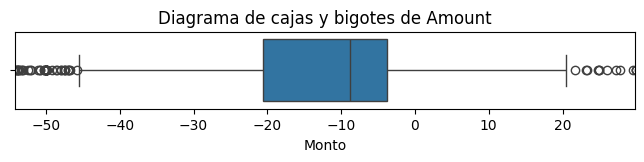

La mayoría de gastos son pequeños ya que:
• Un 25% de los gastos se situan entre -8.87 € y -3.81 € 
• Un 50% de los gastos se situan entre -20.61 € y -3.81 € 

Hay un gran rango de datos que se estiende desde : -22055.0 € hasta 505.0 €


In [241]:
Q1 = gastos['Amount'].quantile(0.25)
Q3 = gastos['Amount'].quantile(0.75)
IQR = Q3 - Q1

plt.figure(figsize=(8, 1))
sns.boxplot(x=gastos['Amount'])
plt.title("Diagrama de cajas y bigotes de Amount")
plt.xlabel("Monto")
plt.xlim(Q1 - 2 * IQR, Q3 + 2 * IQR)  # Limitar eje x
plt.show()

print("La distribución es razonable. La mayoría de gastos son pequeños. Se ve que:")
print(f"• Un 25% de los gastos se situan entre {desc_amount['50%']:.2f} € y {desc_amount['75%']:.2f} € ")
print(f"• Un 50% de los gastos se situan entre {desc_amount['25%']:.2f} € y {desc_amount['75%']:.2f} € ")


print(f"\nHay un gran rango de datos que se estiende desde : {desc_amount['min']} € hasta {desc_amount['max']} €")

In [ ]:
print("Excepto un outlier, todos los valores parecen dentro de razonables")

print(f"El outlier es el máximo de 'Amount' de {desc_amount['max']}. Muy alto para una compartición de gastos\n")

print(gastos.loc[gastos['Amount'].idxmax()]) # mostramos el dato de máximo "Amount"

print("\nVemos que este dato es un regalo de Navidad que quizás no debería ir en este registro.")

In [ ]:
print("La siguiente cantidad de compartición de gastos más alta es:")
print(gastos.nlargest(2, 'Amount').iloc[1])
print("\nque es un valor correcto dentro del contexto de los datos (no outlier)")

## 1.10 ¿Los formatos (fechas, categorías) están normalizados?

### 1.10.1 Normalización de fechas

Todas las fechas estaban en un formato inválido 'object' pero se cambiaron todas a un formato normalizado de datetime con:
```
gastos['Date'] = pd.to_datetime(gastos['Date'], errors='coerce')
```

In [275]:
print(f"Tras el cambio, el formato de fecha es {gastos['Date'].dtype}.")
print(f"Y el número de fechas inválidas es {len(gastos[gastos['Date'].isna()])}.")

Tras el cambio, el formato de fecha es datetime64[ns].
Y el número de fechas inválidas es 0.


In [276]:
print(f"Las fechas están normalizadas y así podemos trabajar su formato.")
print(gastos['Date'].dt.strftime('%Y-%m-%d').head(5))

Las fechas están normalizadas y así podemos trabajar su formato.
0    2025-11-29
1    2025-11-29
2    2025-11-29
3    2025-11-16
4    2025-11-14
Name: Date, dtype: object


### 1.10.2 Normalización de categorías

In [287]:
print(f"En el apartado 1.4.3 se descubrió que existen muchas ({gastos['Category'].nunique()}) categorías distintas. En concreto estas:\n")
gastos['Category'].unique()


En el apartado 1.4.3 se descubrió que existen muchas (47) categorías distintas. En concreto estas:



array(['Transportation', 'Food', 'Gasolina', 'Prendre Algo', 'Atraccions',
       'Sexe', 'Gift', 'Bàsquet', 'Gasolina Compartida',
       'Cotxe Compartit', 'Alcohol', 'Obligatori', 'Tennis', 'Snacks',
       'Supermercat', 'Car', 'Pàrquing', 'Tren', 'Health', 'Perruqueria',
       'Material Ruta', 'Home', 'Furgo', 'Peatge', 'Allotjament', 'Bizum',
       'Vols', 'Lloguer Cotxe', 'Education', 'Projecte Boscos', 'Esquiar',
       'Bici', 'Roba', 'Work', 'Banc', 'Casament', 'Blablacar',
       'Banc Sabadell', 'Excursió', 'Teatre I Cinema', 'Salou',
       'Jocs Cartes / Taula', 'Pizza', 'Llibreria', 'Paintball',
       'Entertainment', 'Educació'], dtype=object)

In [282]:
print("• Las categorías no están normalizadas ya que estan en distintos idiomas ")
print("• No existe una forma estándar de clasificar los gastos. Muchas categorías dificulta un buen análisi descriptivo de las finanzas.")

• Las categorías no están normalizadas ya que estan en distintos idiomas 
• No existe una forma estándar de clasificar los gastos. Muchas categorías dificulta un buen análisi descriptivo de las finanzas.

Se normalizan las categorías, agrupándolas y en el mismo idioma.


## 1.11 ¿Existen incoherencias entre columnas?

# 2 Limpieza

(Corrección de tipos, Tratamiento de nulos, Eliminación o tratamiento de duplicados, Normalización de categorías y fechas, Justificación de cada decisión.)

## 2.1 Corregir tipos de datos

En el apartado '1.3 Inspeccionar los tipos de datos' se cambió el tipo de dato de 'Date' de 'object' a 'datetime' para continuar con el análisis.

Eso se hizo aplicando:
```
gastos['Date'] = pd.to_datetime(gastos['Date'], errors='coerce')
```

Los otros tipos de datos están correctos, como se verificó en '1.3 Inspeccionar los tipos de datos'.

## 2.2 Gestionar valores nulos de forma justificada.

No hay ningún valor nulo en el dataset.

## 2.3 Eliminar o tratar duplicados.

In [242]:
# Eliminar filas duplicadas en todas las columnas
print("Se eliminan filas que estan duplicadas ya que corresponde a una doble introducción errónea del mismo dato.")
print("Las filas eliminadas son:")
gastos[gastos.duplicated(keep='first')]
gastos = gastos.drop_duplicates()

Se eliminan filas que estan duplicadas ya que corresponde a una doble introducción errónea del mismo dato.
Las filas eliminadas son:


## 2.4 Normalizar categorías.

En 1.10.2 se detectó que las categorías no estaban normalizadas, debido a:
- Estar en distintos idiomas
- Haber muchas categorías específicas no estandarizadas

Por esa razón normalizan las categorías, agrupándolas y en el mismo idioma.


In [ ]:
# Agrupar categorías más generales y con nombres en Español
category_mapping = {
    # Alimentación
    'Food': 'Alimentación',
    'Supermercat': 'Alimentación',
    'Prendre Algo': 'Alimentación',
    'Snacks': 'Alimentación',
    'Pizza': 'Alimentación',
    'Alcohol': 'Alimentación',

    # Gasolina
    'Gasolina': 'Gasolina',

    # Transporte coche
    'Car': 'Coche',
    'Furgo': 'Coche',
    'Peatge': 'Coche',
    'Pàrquing': 'Coche',
    'Cotxe Compartit': 'Coche',

    # Transporte otros medios
    'Transportation': 'Transporte',
    'Tren': 'Transporte',
    'Bici': 'Transporte',
    'Vols': 'Transporte',
    'Lloguer Cotxe': 'Transporte',

    # Ocio y Entretenimiento
    'Atraccions': 'Ocio y Entretenimiento',
    'Tennis': 'Ocio y Entretenimiento',
    'Bàsquet': 'Ocio y Entretenimiento',
    'Esquiar': 'Ocio y Entretenimiento',
    'Paintball': 'Ocio y Entretenimiento',
    'Teatre I Cinema': 'Ocio y Entretenimiento',
    'Jocs Cartes / Taula': 'Ocio y Entretenimiento',
    'Entertainment': 'Ocio y Entretenimiento',
    'Material Ruta': 'Ocio y Entretenimiento',
    'Excursió': 'Ocio y Entretenimiento',

    # Alojamiento
    'Allotjament': 'Alojamiento',

    # Ropa
    'Roba': 'Ropa',
    'Perruqueria': 'Ropa',
    'Casament': 'Ropa',

    # Regalos y Donaciones
    'Gift': 'Regalos y Donaciones',
    'Projecte Boscos': 'Regalos y Donaciones',

    # Salud y Hogar
    'Health': 'Salud y Hogar',
    'Home': 'Salud y Hogar',
    'Sexe': 'Salud y Hogar',

    # Educación
    'Work': 'Educación',
    'Education': 'Educación',
    'Educació': 'Educación',
    'Llibreria': 'Educación',

    # Otros
    'Banc': 'Otros', # Comisiones del banco
    'Obligatori': 'Otros', # Gastos de DNI
}

# Crear nueva columna con categoría agrupada
gastos['Grouped category'] = gastos['Category'].map(category_mapping)

In [ ]:
print(f"Ahora las categorías están agrupadas en ({gastos['Grouped category'].nunique()}) categorías distintas que son:\n")
gastos['Grouped category'].unique()

In [ ]:
print("Verificamos dónde han quedado 'Grouped category' que son NaN:\n")

# Filas donde 'Grouped category' es NaN
filas_nan = gastos[gastos['Grouped category'].isna()]

# Categorías únicas para Income/Expenses
categorias_income = filas_nan[filas_nan['Income/Expenses'] == 'Income']['Category'].unique()
categorias_expenses = filas_nan[filas_nan['Income/Expenses'] == 'Expenses']['Category'].unique()

print("Categorías con 'Grouped category' NaN (Income):")
print(categorias_income)

print("\nCategorías con 'Grouped category' NaN (Expenses):")
print(categorias_expenses)

## 2.5 Corregir incoherencias detectadas.

### 2.5.1 Income demasiado alto detectado.

In [243]:
print(f"Se detectó que todos los valores parecen dentro de razonables excepto el máximo de 'Amount' de {desc_amount['max']} que es muy alto para una compartición de gastos\n")

print(gastos.loc[gastos['Amount'].idxmax()]) # mostramos el dato de máximo "Amount"

print("\nVemos que este dato es un regalo de Navidad que no debería ir este registro. Se elimina este registro")
gastos = gastos.drop(gastos['Amount'].idxmax())

Se detectó que todos los valores parecen dentro de razonables excepto el máximo de 'Amount' de 505.0 que es muy alto para una compartición de gastos

Date               2025-01-06 00:00:00
Income/Expenses                 Income
Category                        Salary
Memo                             Papes
Amount                           505.0
Memo_length                          5
Name: 264, dtype: object

Vemos que este dato es un regalo de Navidad que no debería ir este registro. Se elimina este registro


# 3 Visualización básica
mínimo: Histograma, Gráfica de barras, Visualización adicional que aporte información relevante.

Generar visualizaciones sencillas que ayuden a explicar el dataset, respondiendo a preguntas como:

## 3.1 ¿Cómo se distribuye una variable numérica relevante?

## 3.2 ¿Cuáles son las categorías más frecuentes?

## 3.3 ¿Existen diferencias visuales entre grupos?

## 3.4 ¿Cómo varían los valores a lo largo del tiempo (si aplica)?

## 3.5 ¿Qué patrones básicos se detectan tras la limpieza?

# 4 Conclusiones exploratorias

## 4.1 Resumen claro de las características del dataset.

## 4.2 Principales hallazgos.

## 4.3 Cambios aplicados durante la limpieza.